[*********************100%***********************]  1 of 1 completed
C:\Users\Naomie  Fillies\AppData\Local\Temp\ipykernel_16276\3546506676.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_avg_stock_price = stock_price.resample('Y').mean()



Shape of Stock Price Data: (1257, 1)

First few rows of Stock Price Data:
 Ticker            META
Date                  
2020-05-11  212.179977
2020-05-12  209.114441
2020-05-13  204.137909
2020-05-14  205.839874
2020-05-15  209.890778

Financial Ratios:
             Profit Margin  Debt-to-Equity Ratio  Return on Equity
2024-12-31      37.908584              0.268620         34.144231
2023-12-31      28.982521              0.243093         25.526220
2022-12-31      19.895548              0.211521         18.454734
2021-12-31      33.384494              0.111092         31.526518
2020-12-31            NaN                   NaN               NaN

Annual Average Stock Price:
 Ticker            META
Date                  
2020-12-31  256.347077
2021-12-31  319.659672
2022-12-31  179.342448
2023-12-31  260.197965
2024-12-31  507.826973
2025-12-31  613.971902

Merged Data for Correlation:
 Empty DataFrame
Columns: [Profit Margin, Debt-to-Equity Ratio, Return on Equity, META]
Index: []

Corr

C:\Users\Naomie  Fillies\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Naomie  Fillies\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


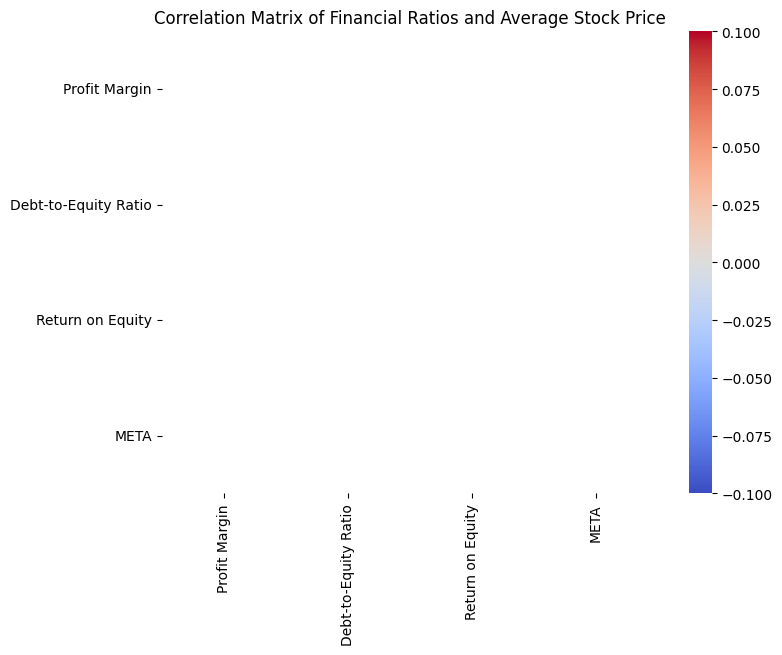

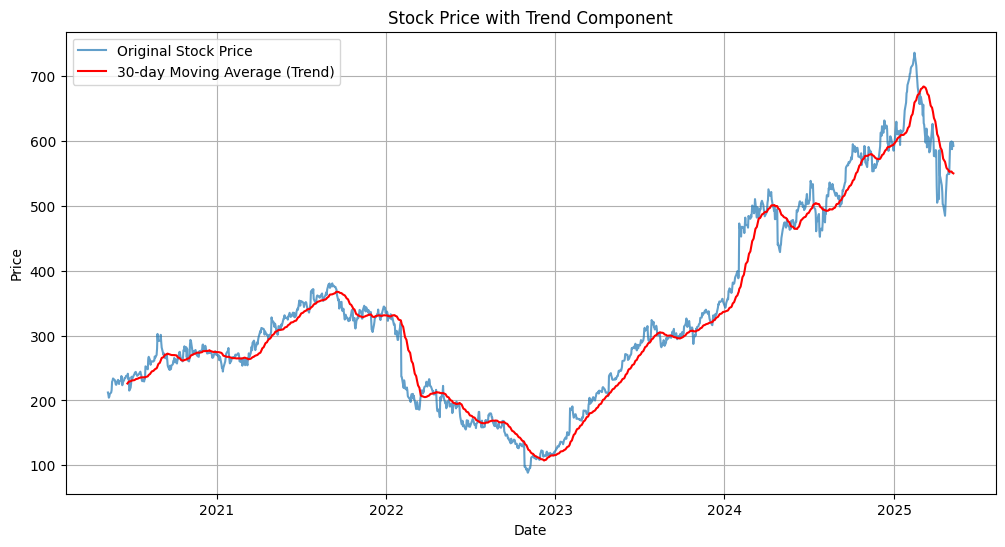

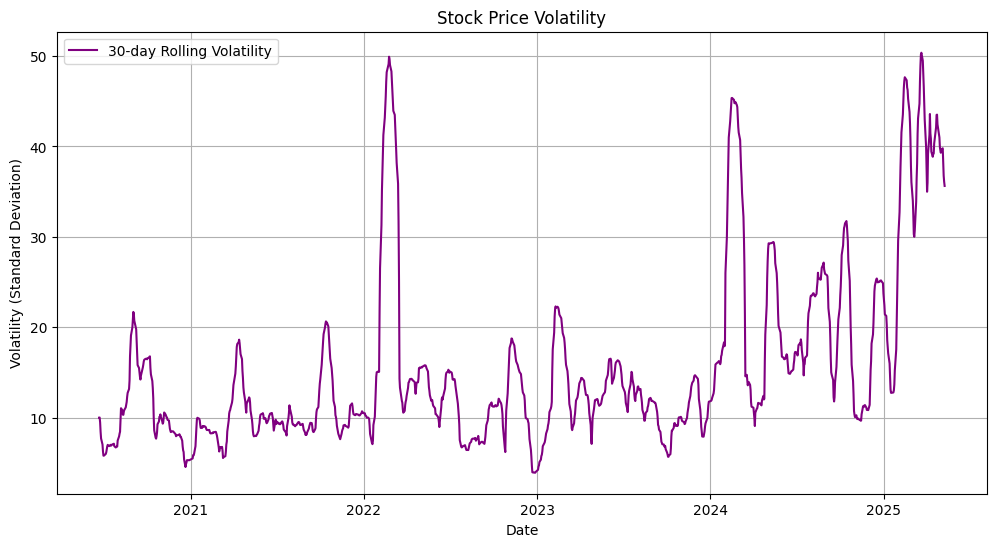


Augmented Dickey-Fuller (ADF) Test on Stock Price:
ADF Statistic: -0.3823769266724752
p-value: 0.9129998785578728
Critical Values:
   1%, -3.435571295403709
   5%, -2.863845736356174
   10%, -2.567997600196822


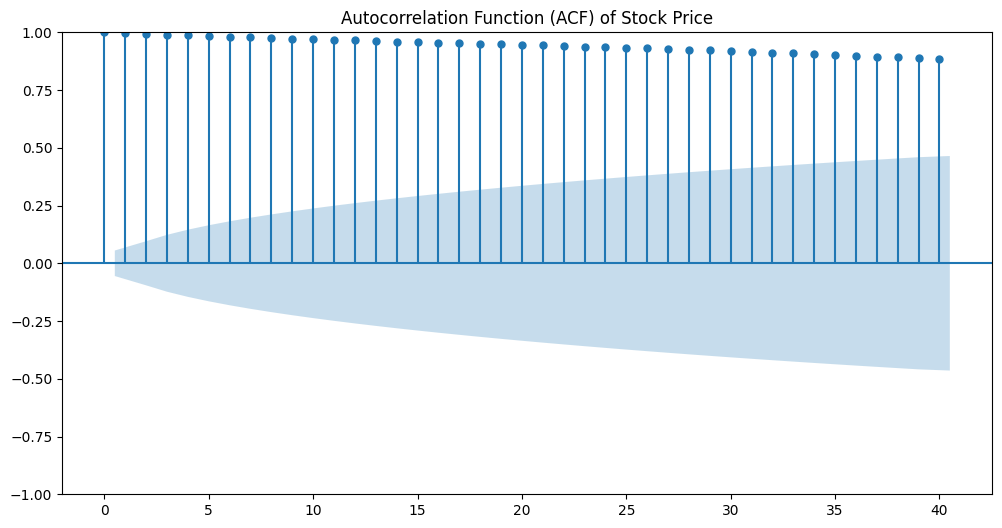

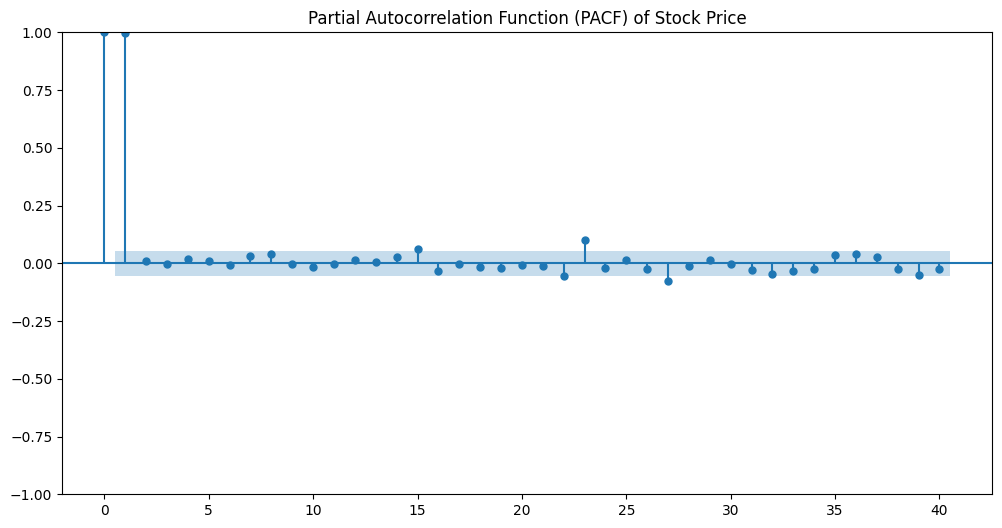

In [24]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

# Define the ticker symbol
ticker = "META"

# Define the period for which to download data
period = "10y"

# --- 1. Download Historical Stock Data ---
meta_stock = yf.download(ticker, period=period)
stock_price = meta_stock['Close'] # Select the 'Close' price
print("\nShape of Stock Price Data:", stock_price.shape)
print("\nFirst few rows of Stock Price Data:\n", stock_price.head())

# --- 2. Function to Fetch Financial Ratios ---
def calculate_financial_ratios(ticker):
    try:
        company = yf.Ticker(ticker)
        balance_sheet = company.balance_sheet.T
        income_statement = company.income_stmt.T
        financial_ratios_data = {}
        years = income_statement.index.astype(str).tolist()

        for year in years:
            income_data = income_statement.loc[year]
            balance_data = balance_sheet.loc[year]
            ratios = {}

            if 'Net Income' in income_data and 'Total Revenue' in income_data and pd.notna(income_data['Total Revenue']) and income_data['Total Revenue'] != 0:
                ratios['Profit Margin'] = (income_data['Net Income'] / income_data['Total Revenue']) * 100
            else:
                ratios['Profit Margin'] = np.nan

            if 'Total Debt' in balance_data and 'Stockholders Equity' in balance_data and pd.notna(balance_data['Stockholders Equity']) and balance_data['Stockholders Equity'] != 0:
                ratios['Debt-to-Equity Ratio'] = balance_data['Total Debt'] / balance_data['Stockholders Equity']
            else:
                ratios['Debt-to-Equity Ratio'] = np.nan

            if 'Net Income' in income_data and 'Stockholders Equity' in balance_data and pd.notna(balance_data['Stockholders Equity']) and balance_data['Stockholders Equity'] != 0:
                ratios['Return on Equity'] = income_data['Net Income'] / balance_data['Stockholders Equity'] * 100
            else:
                ratios['Return on Equity'] = np.nan

            financial_ratios_data[year] = ratios

        financial_ratios_df = pd.DataFrame.from_dict(financial_ratios_data, orient='index')
        return financial_ratios_df
    except Exception as e:
        print(f"Error calculating financial ratios: {e}")
        return None

financial_ratios = calculate_financial_ratios(ticker)
print("\nFinancial Ratios:\n", financial_ratios)

# --- 3. Advanced Exploratory Data Analysis ---

# --- 3.1 Detailed Trend Analysis of Key Financial Ratios ---
if financial_ratios is not None:
    plt.figure(figsize=(15, 5))
    for ratio in financial_ratios.columns:
        plt.plot(financial_ratios.index, financial_ratios[ratio], marker='o', label=ratio)
    plt.title('Trend of Key Financial Ratios')
    plt.xlabel('Year')
    plt.ylabel('Ratio Value (%) or Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nWarning: Financial ratios not available, skipping detailed trend analysis.")

# --- 3.2 Correlation Analysis between Financial Metrics and Stock Price ---
if financial_ratios is not None and not financial_ratios.empty:
    annual_avg_stock_price = stock_price['META'].resample('YE').mean() # Use 'YE' instead of 'Y'
    annual_avg_stock_price.index = annual_avg_stock_price.index.astype(str) # Convert index to string for merging
    correlation_df = pd.merge(financial_ratios, annual_avg_stock_price, left_index=True, right_index=True, how='inner')
    correlation_matrix = correlation_df.corr()
    print("\nCorrelation Matrix of Financial Ratios and Average Stock Price:\n", correlation_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

    # Correlation between financial ratios themselves
    ratio_correlation_matrix = financial_ratios.corr()
    print("\nCorrelation Matrix of Financial Ratios:\n", ratio_correlation_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(ratio_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Financial Ratio Correlation Matrix')
    plt.show()
else:
    print("\nWarning: Financial ratios not available, skipping correlation analysis with stock price.")

# --- 3.3 Stock Price Decomposition ---
# Using seasonal_decompose for trend, seasonality, and residual
decomposition = seasonal_decompose(stock_price['META'].dropna(), model='additive', period=365) # Assuming yearly seasonality, use 'META' column
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 8))
plt.subplot(411)
plt.plot(stock_price['META'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# --- 3.4 Volatility Analysis ---
# Rolling Standard Deviation
rolling_window_volatility = 90 # Quarterly volatility
stock_price_volatility = stock_price['META'].rolling(window=rolling_window_volatility).std() # Use 'META' column

plt.figure(figsize=(15, 6))
plt.plot(stock_price_volatility, label=f'{rolling_window_volatility}-day Rolling Volatility', color='purple')
plt.title('Stock Price Volatility (90-day Rolling)')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Robust Model Selection and Comparison ---

# --- 4.1 Formal Stationarity Testing (ADF Test) ---
print("\nAugmented Dickey-Fuller (ADF) Test on Stock Price:")
adf_result_stock = adfuller(stock_price['META'].dropna()) # Use 'META' column
print(f'ADF Statistic: {adf_result_stock[0]}')
print(f'p-value: {adf_result_stock[1]}')
print('Critical Values:')
for key, value in adf_result_stock[4].items():
    print(f'   {key}, {value}')

# Stationarity testing on financial ratios (annual data)
if financial_ratios is not None:
    print("\nAugmented Dickey-Fuller (ADF) Test on Financial Ratios:")
    for ratio in financial_ratios.columns:
        adf_result_ratio = adfuller(financial_ratios[ratio].dropna())
        print(f'\nADF Test on {ratio}:')
        print(f'   ADF Statistic: {adf_result_ratio[0]}')
        print(f'   p-value: {adf_result_ratio[1]}')
        print('   Critical Values:')
        for key, value in adf_result_ratio[4].items():
            print(f'      {key}, {value}')
else:
    print("\nWarning: Financial ratios not available, skipping stationarity testing on ratios.")

# --- 4.2 Utilizing ACF and PACF Plots for ARIMA Order Selection ---
plt.figure(figsize=(15, 6))
plot_acf(stock_price['META'].dropna(), lags=40, ax=plt.gca()) # Use 'META' column
plt.title('Autocorrelation Function (ACF) of Stock Price')
plt.show()

plt.figure(figsize=(15, 6))
plot_pacf(stock_price['META'].dropna(), lags=40, ax=plt.gca()) # Use 'META' column
plt.title('Partial Autocorrelation Function (PACF) of Stock Price')
plt.show()

# --- 4.3 ARIMA Model Fitting and Diagnostics ---
# Example fitting an ARIMA(5,1,0) model (order chosen based on ACF/PACF - might need adjustment)
train_size = int(len(stock_price['META']) * 0.8) # Use 'META' column
train, test = stock_price['META'][:train_size], stock_price['META'][train_size:] # Use 'META' column

history = [x for x in train]
predictions = []

try:
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test.iloc[t] # Use .iloc for positional indexing
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f'\nARIMA RMSE: {rmse}')

    # Residual Analysis
    residuals = model_fit.resid
    plt.figure(figsize=(15, 6))
    plt.plot(residuals)
    plt.title('ARIMA Model Residuals')
    plt.show()

    plt.figure(figsize=(15, 6))
    plot_acf(residuals, lags=40, ax=plt.gca())
    plt.title('ACF of ARIMA Model Residuals')
    plt.show()
except Exception as e:
    print(f"\nError fitting ARIMA model: {e}")

# --- 4.4 Comparison with Exponential Smoothing (Holt-Winters) ---
try:
    model_es = ExponentialSmoothing(train, seasonal_periods=365, trend='add', seasonal='add').fit()
    predictions_es = model_es.forecast(len(test))
    rmse_es = sqrt(mean_squared_error(test, predictions_es))
    print(f'\nExponential Smoothing RMSE: {rmse_es}')

    plt.figure(figsize=(15, 6))
    plt.plot(test, label='Actual')
    plt.plot(predictions_es, label='Exponential Smoothing Forecast')
    plt.title('Exponential Smoothing Forecast vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"\nError fitting Exponential Smoothing model: {e}")

import matplotlib.pyplot as plt

try:
    sp500 = yf.download("^GSPC", period=period)['Close']
    external_data = pd.merge(stock_price['META'], sp500, left_index=True, right_index=True, how='inner')
    external_data.rename(columns={'Close_x': 'META', 'Close_y': '^GSPC'}, inplace=True)
    print("\nData with S&P 500:\n", external_data.head())

    # Simple correlation with S&P 500
    correlation_sp500 = external_data['META'].corr(external_data['^GSPC'])
    print(f"\nCorrelation with S&P 500: {correlation_sp500:.2f}")

    # Plotting code extracted from your notebook:
    plt.figure(figsize=(15, 6))
    plt.plot(external_data.index, external_data['META'], label='META')
    plt.plot(external_data.index, external_data['^GSPC'], label='S&P 500')
    plt.title('META Stock Price vs. S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # More advanced multivariate models (e.g., VAR) would go here.

except Exception as e:
    print(f"\nError incorporating S&P 500 data: {e}")
# --- 6. Enhanced Evaluation and Validation ---

# --- 6.2 Backtesting (Simple Example with ARIMA) ---
n_periods = 90 # Backtest over the last 90 days
history_backtest = [x for x in stock_price['META'][:-n_periods]] # Use 'META' column
predictions_backtest = []
actual_backtest = stock_price['META'][-n_periods:].tolist() # Use 'META' column and then tolist()

try:
    for t in range(n_periods):
        model = ARIMA(history_backtest, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions_backtest.append(yhat)
        obs = actual_backtest[t]
        history_backtest.append(obs)
    rmse_backtest = sqrt(mean_squared_error(actual_backtest, predictions_backtest))
    print(f'\nARIMA Backtesting RMSE over last {n_periods} days: {rmse_backtest}')

    plt.figure(figsize=(15, 6))
    plt.plot(actual_backtest, label='Actual')
    plt.plot(predictions_backtest, label='ARIMA Backtest Predictions', color='red')
    plt.title('ARIMA Backtesting')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"\nError during ARIMA backtesting: {e}")

# --- 6.3 Confidence Intervals (ARIMA Example) ---
try:
    model_final = ARIMA(stock_price['META'], order=(5,1,0)).fit() # Use 'META' column
    forecast = model_final.get_forecast(steps=30) # Forecast for the next 30 days
    forecast_ci = forecast.conf_int(alpha=0.05) # 95% confidence interval
    print("\nARIMA Forecast for the next 30 days:")
    print(forecast.predicted_mean)
    print("\nConfidence Intervals:")
    print(forecast_ci)

    # Plotting the forecast with confidence intervals
    plt.figure(figsize=(15, 6))
    plt.plot(stock_price['META'][-365:], label='Historical')
    plt.plot(forecast.index, forecast.predicted_mean, color='red', label='Forecast')
    plt.fill_between(forecast.index, forecast_ci[:, 0], forecast_ci[:, 1], color='pink', alpha=0.2, label='95% CI')
    plt.title('ARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"\nError generating ARIMA forecast with confidence intervals: {e}")